In [40]:
import sys, os
print("Python:", sys.version)
print("Working dir:", os.getcwd())

# Basic imports
import json
import math
import time
import platform
from pprint import pprint

# Check memory/CPU
try:
    import psutil
    print("CPUs:", psutil.cpu_count(logical=True))
    vm = psutil.virtual_memory()
    print("Total RAM (GB):", round(vm.total/1024**3,2))
except Exception as e:
    print("psutil not available:", e)

print("\nIf any pip installs failed, install them manually (conda/pip) and re-run this cell.")


Python: 3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]
Working dir: C:\Users\HP
CPUs: 12
Total RAM (GB): 7.33

If any pip installs failed, install them manually (conda/pip) and re-run this cell.


In [41]:
# Load CSV and inspect
import pandas as pd
CSV_FILE = 'complaints.csv' 
# Read a tiny sample to detect column names and a few rows
df_head = pd.read_csv(CSV_FILE, nrows=10, low_memory=False, on_bad_lines='skip', encoding='utf-8')

In [42]:
df_head.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-07-06,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,346XX,NaN,Other,Web,2020-07-06,Closed with explanation,Yes,NaN,3730948
1,2025-09-24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",KS,67206,NaN,NaN,Web,2025-09-24,In progress,Yes,NaN,16152255
2,2019-12-26,Credit card or prepaid card,General-purpose credit card or charge card,"Advertising and marketing, including promotion...",Confusing or misleading advertising about the ...,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,CA,94025,NaN,Consent not provided,Web,2019-12-26,Closed with explanation,Yes,NaN,3477549
3,2020-05-08,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,These are not my accounts.,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NV,89030,NaN,Consent provided,Web,2020-05-08,Closed with explanation,Yes,NaN,3642453
4,2025-09-23,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,CA,93630,NaN,NaN,Web,2025-09-23,In progress,Yes,NaN,16077048


In [43]:
print(df_head.columns)
print(df_head.shape)

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')
(10, 18)


In [44]:
# Auto-detect text & product columns 
possible_text_cols = [
    'consumer_complaint_narrative',
    'Consumer complaint narrative',
    'complaint_what_happened',
    'complaint_what_happend',  # for the typos
    'description',
    'description_of_issue',
    'what_happened',
    'consumer_complaint',
    'narrative'
]

possible_product_cols = [
    'product', 'Product', 'product_name', 'product_type'
]

cols = [c.lower() for c in df_head.columns.tolist()]
col_map = {c.lower(): c for c in df_head.columns.tolist()}

In [45]:

def find_first(candidates):
    # Exact match first
    for cand in candidates:
        if cand.lower() in col_map:
            return col_map[cand.lower()]
    # partial match (case-insensitive)
    for name in col_map:
        for cand in candidates:
            if cand.lower() in name.lower():
                return col_map[name]
    return None

text_col = find_first(possible_text_cols)
product_col = find_first(possible_product_cols)

print("Auto-detected text_col:", text_col)
print("Auto-detected product_col:", product_col)

if text_col is None or product_col is None:
    print("\nCould not detect automatically. Here are all columns again; please edit DATA_TEXT_COL and DATA_PRODUCT_COL variables manually and re-run cell:")
    print(df_head.columns.tolist())
else:
    print("\nLooks good. We'll use these columns. If you'd like to override, edit the variables below and re-run.")

# Override if needed:
DATA_TEXT_COL = text_col
DATA_PRODUCT_COL = product_col

print("\nFinal text col:", DATA_TEXT_COL)
print("Final product col:", DATA_PRODUCT_COL)
3

Auto-detected text_col: Consumer complaint narrative
Auto-detected product_col: Product

Looks good. We'll use these columns. If you'd like to override, edit the variables below and re-run.

Final text col: Consumer complaint narrative
Final product col: Product


3

In [46]:
# Build a stratified sample CSV file
import pandas as pd
from tqdm.auto import tqdm

#  PARAMETERS
CSV_FILE = "complaints.csv"  
OUTPUT_SAMPLE_CSV = "complaints_stratified_sample.csv"
SAMPLES_PER_CLASS = 5000
TEXT_COLUMN = DATA_TEXT_COL
PRODUCT_COLUMN = DATA_PRODUCT_COL
CHUNK_SIZE = 200_000  

# Mapping rules for product classes
product_mapping = {
    0: ["credit reporting", "credit report", "credit reporting, repair, or other", "credit reporting/repair"],
    1: ["debt collection", "debt-collection", "debt collection/collection"],
    2: ["consumer loan", "consumer loans", "consumer loan/vehicle loan", "personal loan"],
    3: ["mortgage", "home mortgage", "home mortgage loan"]
}

# Storage for sampled rows
class_counts = {label: 0 for label in product_mapping}
class_buffers = {label: [] for label in product_mapping}

# Function to map product name to class label
def map_product_to_class(product_name):
    if pd.isna(product_name):
        return None
    name_lower = str(product_name).lower()
    for label, keywords in product_mapping.items():
        if any(kw in name_lower for kw in keywords):
            return label
    return None

# Read CSV in chunks to handle large/malformed data
chunk_reader = pd.read_csv(
    CSV_FILE,
    chunksize=CHUNK_SIZE,
    low_memory=False,
    on_bad_lines='skip',
    encoding='utf-8',
    usecols=[PRODUCT_COLUMN, TEXT_COLUMN]
)

pbar = tqdm(desc="Sampling chunks")
for chunk in chunk_reader:
    chunk = chunk.dropna(subset=[TEXT_COLUMN])
    chunk['target'] = chunk[PRODUCT_COLUMN].apply(map_product_to_class)
    
    # Group by target label and fill buffers
    for label, group in chunk.groupby('target'):
        if label not in class_counts or class_counts[label] >= SAMPLES_PER_CLASS:
            continue
        needed = SAMPLES_PER_CLASS - class_counts[label]
        selected_rows = group.head(needed)
        class_buffers[label].append(selected_rows[[PRODUCT_COLUMN, TEXT_COLUMN]])
        class_counts[label] += len(selected_rows)
    
    # Stop early if all classes are filled
    if all(count >= SAMPLES_PER_CLASS for count in class_counts.values()):
        break
    pbar.update(1)
pbar.close()

print("Collected counts per class:", class_counts)

# Combine buffers into final DataFrame
all_samples = []
for label, buffer_list in class_buffers.items():
    if buffer_list:
        combined = pd.concat(buffer_list, ignore_index=True)
        combined['target'] = label
        all_samples.append(combined)

if not all_samples:
    raise RuntimeError("No rows matched the product mapping rules. Check product column values.")

sample_df = pd.concat(all_samples, ignore_index=True)
# Shuffle rows
sample_df = sample_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Save to CSV
sample_df.to_csv(OUTPUT_SAMPLE_CSV, index=False)
print(f"Saved stratified sample CSV to {OUTPUT_SAMPLE_CSV}, shape: {sample_df.shape}")


Sampling chunks: 0it [00:00, ?it/s]

Collected counts per class: {0: 5000, 1: 5000, 2: 5000, 3: 5000}
Saved stratified sample CSV to complaints_stratified_sample.csv, shape: (20000, 3)


Sample loaded: (20000, 3)

Text length stats (characters):
count    20000.00000
mean      1232.34145
std       1541.05225
min          4.00000
25%        376.00000
50%        764.00000
75%       1506.50000
max      31856.00000
Name: Consumer complaint narrative, dtype: float64


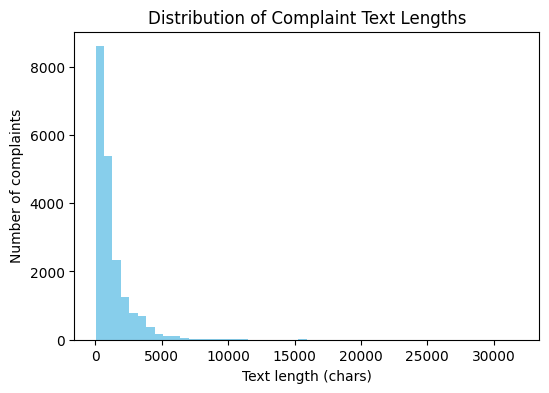


Class distribution:
target
0    5000
1    5000
2    5000
3    5000
dtype: int64


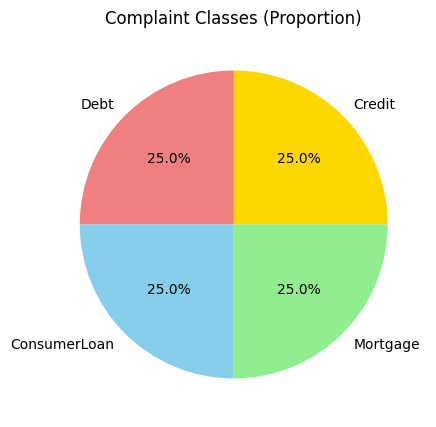


Top 25 words (from random 5k texts):
the: 44857
xxxx: 44036
to: 35404
and: 28284
of: 19821
my: 19731
that: 14925
was: 12064
in: 12048
this: 11195
on: 10773
they: 10093
for: 9849
is: 9830
not: 9751
have: 9225
with: 8446
me: 7105
credit: 7036
it: 6098
from: 6035
as: 5798
be: 5058
account: 4818
or: 4597

Average text length per class:
target
0     960.4204
1     968.5478
2    1207.8254
3    1792.5722
Name: Consumer complaint narrative, dtype: float64


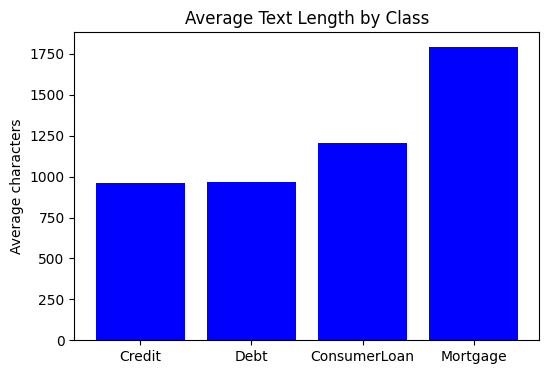

In [47]:
# Cell 5: Enhanced EDA on stratified sample (unique approach)
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# === PARAMETERS ===
SAMPLE_CSV = "complaints_stratified_sample.csv"
df = pd.read_csv(SAMPLE_CSV)

print("Sample loaded:", df.shape)

text_lengths = df[DATA_TEXT_COL].dropna().astype(str).apply(len)
print("\nText length stats (characters):")
print(text_lengths.describe())

# Plot histogram of text lengths
plt.figure(figsize=(6,4))
plt.hist(text_lengths, bins=50, color='skyblue')
plt.title("Distribution of Complaint Text Lengths")
plt.xlabel("Text length (chars)")
plt.ylabel("Number of complaints")
plt.show()

# --- 2. Class distribution second ---
class_counts = df.groupby('target').size()
print("\nClass distribution:")
print(class_counts)

# Pie chart for class distribution
plt.figure(figsize=(5,5))
plt.pie(class_counts, labels=['Credit','Debt','ConsumerLoan','Mortgage'], autopct='%1.1f%%', colors=['gold','lightcoral','skyblue','lightgreen'])
plt.title("Complaint Classes (Proportion)")
plt.show()

# --- 3. Simple word frequency (tokenization with split) ---
sample_texts = df[DATA_TEXT_COL].dropna().sample(n=min(5000, len(df)), random_state=42)
word_freq = defaultdict(int)
for txt in sample_texts:
    for word in str(txt).lower().split():
        if word.isalpha() and len(word) > 1:
            word_freq[word] += 1

top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:25]
print("\nTop 25 words (from random 5k texts):")
for w, f in top_words:
    print(f"{w}: {f}")

# --- 4. Average text length per class ---
avg_len_per_class = df.groupby('target')[DATA_TEXT_COL].apply(lambda x: np.mean(x.astype(str).str.len()))
print("\nAverage text length per class:")
print(avg_len_per_class)

plt.figure(figsize=(6,4))
plt.bar(['Credit','Debt','ConsumerLoan','Mortgage'], avg_len_per_class, color='blue')
plt.title("Average Text Length by Class")
plt.ylabel("Average characters")
plt.show()


In [48]:
# Text preprocessing and train/test split
import pandas as pd
from sklearn.model_selection import train_test_split
import re

# Load the stratified sample
df = pd.read_csv("complaints_stratified_sample.csv")

# 1. Clean text function 
def clean_text(text):
    """
    Lowercase, remove non-alphabetic characters,
    extra spaces, and short words (<2 chars)
    """
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)   # remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    tokens = [w for w in text.split() if len(w) > 1]
    return " ".join(tokens)

# Apply text cleaning
df['clean_text'] = df[DATA_TEXT_COL].apply(clean_text)

# 2. Train/Test split (80/20) 
X = df['clean_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train set:", X_train.shape, "Test set:", X_test.shape)
print("Class distribution in train set:\n", y_train.value_counts())


Train set: (16000,) Test set: (4000,)
Class distribution in train set:
 target
3    4000
0    4000
1    4000
2    4000
Name: count, dtype: int64


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF feature shape (train):", X_train_tfidf.shape)
print("TF-IDF feature shape (test):", X_test_tfidf.shape)

TF-IDF feature shape (train): (16000, 5000)
TF-IDF feature shape (test): (4000, 5000)



Training LogisticRegression...
LogisticRegression trained in 2.79s
              precision    recall  f1-score   support

           0     0.8130    0.8910    0.8502      1000
           1     0.8436    0.7660    0.8029      1000
           2     0.8171    0.8490    0.8328      1000
           3     0.9436    0.9030    0.9228      1000

    accuracy                         0.8522      4000
   macro avg     0.8543    0.8523    0.8522      4000
weighted avg     0.8543    0.8522    0.8522      4000

Macro F1 score: 0.8521820227244252


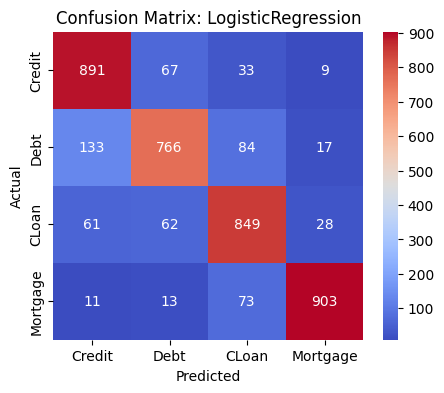


Training MultinomialNB...
MultinomialNB trained in 0.02s
              precision    recall  f1-score   support

           0     0.7880    0.8440    0.8151      1000
           1     0.7975    0.6500    0.7163      1000
           2     0.7439    0.8220    0.7810      1000
           3     0.9039    0.9120    0.9079      1000

    accuracy                         0.8070      4000
   macro avg     0.8083    0.8070    0.8051      4000
weighted avg     0.8083    0.8070    0.8051      4000

Macro F1 score: 0.8050576598490229


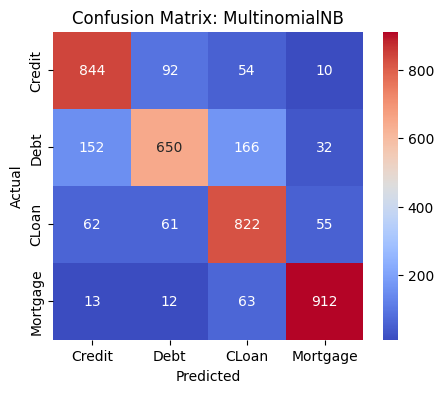

['model_logreg_safe.joblib']

In [52]:
# Train & compare two text classifiers
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, confusion_matrix

# Dictionary of models
models_to_train = {
    "LogisticRegression": LogisticRegression(max_iter=2000, solver='saga', class_weight='balanced', n_jobs=-1),
    "MultinomialNB": MultinomialNB()
}

trained_models = {}

# Loop through models
for name, model in models_to_train.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    model.fit(X_train_tfidf, y_train)
    end_time = time.time()
    print(f"{name} trained in {end_time - start_time:.2f}s")
    
    # Predictions
    y_pred = model.predict(X_test_tfidf)
    
    # Classification report
    print(classification_report(y_test, y_pred, digits=4))
    print("Macro F1 score:", f1_score(y_test, y_pred, average='macro'))
    
    # Confusion matrix as heatmap
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Credit','Debt','CLoan','Mortgage'], yticklabels=['Credit','Debt','CLoan','Mortgage'])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    trained_models[name] = model

# Save TF-IDF vectorizer and best model (Logistic Regression)
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer_safe.joblib")
joblib.dump(trained_models["LogisticRegression"], "model_logreg_safe.joblib")


In [53]:
# Cell 8: Predict on new complaints
import joblib

# Load saved vectorizer and model
vectorizer = joblib.load("tfidf_vectorizer_safe.joblib")
model = joblib.load("model_logreg_safe.joblib")

# Example new complaints (replace with any new data)
new_complaints = [
    "I have an issue with incorrect information on my credit report.",
    "Debt collectors keep calling me and threatening legal action.",
    "I want to apply for a personal loan for my car.",
    "Problems with my home mortgage application process."
]

# Optional: clean text if you used a preprocessing function
def clean_text(text):
    return str(text).lower().strip()

cleaned_texts = [clean_text(txt) for txt in new_complaints]

# Transform to TF-IDF
X_new = vectorizer.transform(cleaned_texts)

# Predict classes
predictions = model.predict(X_new)
prediction_probs = model.predict_proba(X_new)

# Display results
for txt, pred, probs in zip(new_complaints, predictions, prediction_probs):
    print(f"Complaint: {txt}")
    print(f"Predicted class: {pred}  | Probabilities: {probs}\n")


Complaint: I have an issue with incorrect information on my credit report.
Predicted class: 0  | Probabilities: [0.8312494  0.08937169 0.06278336 0.01659555]

Complaint: Debt collectors keep calling me and threatening legal action.
Predicted class: 1  | Probabilities: [0.02316676 0.94931031 0.02552159 0.00200135]

Complaint: I want to apply for a personal loan for my car.
Predicted class: 2  | Probabilities: [0.00840412 0.00548871 0.98397762 0.00212955]

Complaint: Problems with my home mortgage application process.
Predicted class: 3  | Probabilities: [0.00392248 0.00106829 0.00103914 0.99397009]

